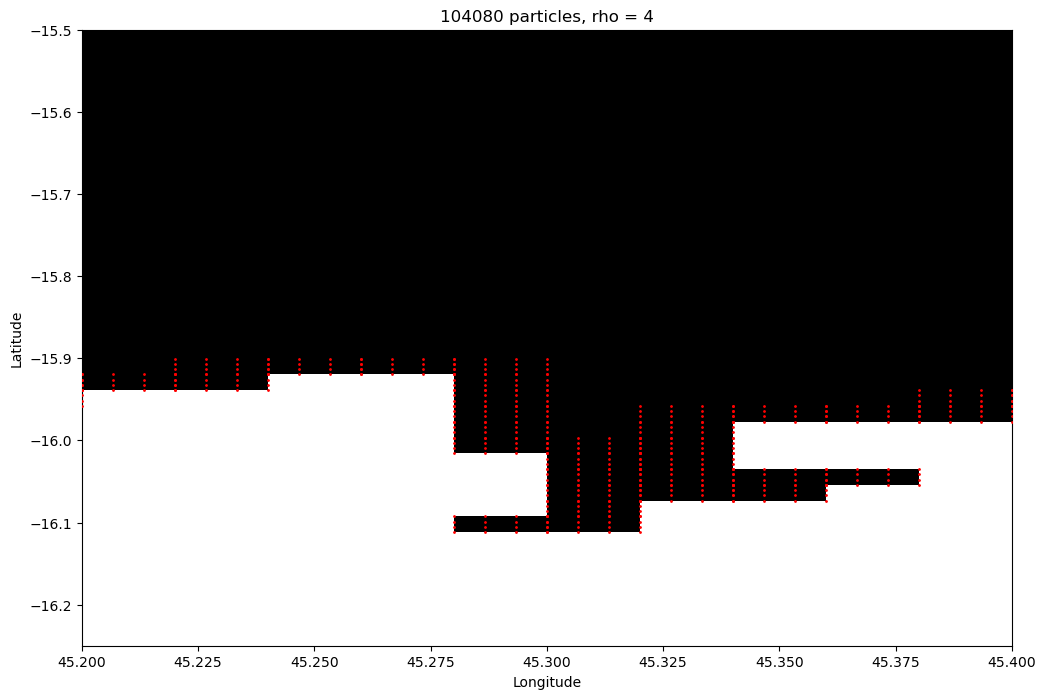

In [57]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt


file_path = '/home/ocean_personal_data/albinski/croco_grd.nc' 
grid_data = xr.open_dataset(file_path)


mask_psi = grid_data['mask_psi'].values
lat_psi = grid_data['lat_psi'].values
lon_psi = grid_data['lon_psi'].values


adjacent_ocean_cells = np.zeros_like(mask_psi, dtype=bool)


for i in range(1, mask_psi.shape[0] - 1):
    for j in range(1, mask_psi.shape[1] - 1):
        
        if mask_psi[i, j] == 1 and (
            mask_psi[i-1, j] == 0 or mask_psi[i+1, j] == 0 or 
            mask_psi[i, j-1] == 0 or mask_psi[i, j+1] == 0 or
            mask_psi[i-1, j-1] == 0 or mask_psi[i-1, j+1] == 0 or
            mask_psi[i+1, j-1] == 0 or mask_psi[i+1, j+1] == 0):
            adjacent_ocean_cells[i, j] = True


adjacent_ocean_indices = np.argwhere(adjacent_ocean_cells)

particles_per_cell = 4

particle_lons, particle_lats = [], []

for i, j in adjacent_ocean_indices:
    dlon = np.diff(lon_psi[i:i+2, j:j+2], axis=1)
    dlat = np.diff(lat_psi[i:i+2, j:j+2], axis=0)
    start_lon = lon_psi[i, j] - dlon[0, 0] / 2 if dlon.size > 0 else lon_psi[i, j]
    start_lat = lat_psi[i, j] - dlat[0, 0] / 2 if dlat.size > 0 else lat_psi[i, j]

    
    for lat_index in range(particles_per_cell):
        for lon_index in range(particles_per_cell):
            particle_lat = start_lat + (lat_index / (particles_per_cell - 1)) * (dlat[0, 0] if dlat.size > 0 else 0)
            particle_lon = start_lon + (lon_index / (particles_per_cell - 1)) * (dlon[0, 0] if dlon.size > 0 else 0)

            
            particle_lons.append(particle_lon)
            particle_lats.append(particle_lat)


plt.figure(figsize=(12, 8))
plt.pcolormesh(lon_psi, lat_psi, mask_psi, cmap='bone_r', shading='auto', zorder = 1)
plt.scatter(particle_lons, particle_lats, color='red', s=1, zorder=10)  
n = len(particle_lats)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'{n} particles, rho = {particles_per_cell}')
plt.ylim(-16.25,-15.50)
plt.xlim(45.2, 45.4)
plt.show()


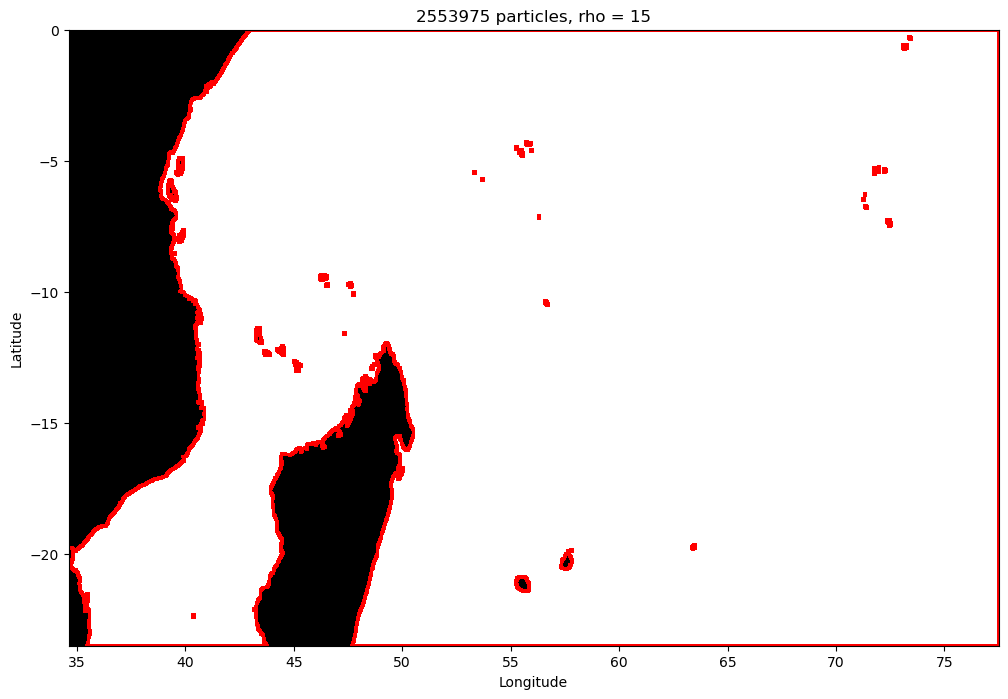

In [8]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

file_path = '/home/ocean_personal_data/albinski/croco_grd.nc' 
grid_data = xr.open_dataset(file_path)

mask_psi = grid_data['mask_psi'].values
lat_psi = grid_data['lat_psi'].values
lon_psi = grid_data['lon_psi'].values

padded_mask = np.pad(mask_psi, pad_width=1, mode='constant', constant_values=0)

shift_up = padded_mask[:-2, 1:-1]
shift_down = padded_mask[2:, 1:-1]
shift_left = padded_mask[1:-1, :-2]
shift_right = padded_mask[1:-1, 2:]
shift_up_left = padded_mask[:-2, :-2]
shift_up_right = padded_mask[:-2, 2:]
shift_down_left = padded_mask[2:, :-2]
shift_down_right = padded_mask[2:, 2:]

adjacent_to_land = ((shift_up == 0) | (shift_down == 0) | (shift_left == 0) | (shift_right == 0) |
                    (shift_up_left == 0) | (shift_up_right == 0) | (shift_down_left == 0) | (shift_down_right == 0))

adjacent_ocean_cells = adjacent_to_land & (mask_psi == 1)
adjacent_ocean_indices = np.argwhere(adjacent_ocean_cells)

particles_per_cell = 15

particle_lons, particle_lats = [], []

for i, j in adjacent_ocean_indices:
    dlon = np.diff(lon_psi[i:i+2, j:j+2], axis=1)
    dlat = np.diff(lat_psi[i:i+2, j:j+2], axis=0)

    start_lon = lon_psi[i, j] - dlon[0, 0] / 2 if dlon.size > 0 else lon_psi[i, j]
    start_lat = lat_psi[i, j] - dlat[0, 0] / 2 if dlat.size > 0 else lat_psi[i, j]

    for lat_index in range(particles_per_cell):
        for lon_index in range(particles_per_cell):
            particle_lat = start_lat + (lat_index / (particles_per_cell - 1)) * (dlat[0, 0] if dlat.size > 0 else 0)
            particle_lon = start_lon + (lon_index / (particles_per_cell - 1)) * (dlon[0, 0] if dlon.size > 0 else 0)

            particle_lons.append(particle_lon)
            particle_lats.append(particle_lat)

plt.figure(figsize=(12, 8))

plt.pcolormesh(lon_psi, lat_psi, mask_psi, cmap='bone', shading='auto')

plt.scatter(particle_lons, particle_lats, color='red', s=1)
n = len(particle_lats)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'{n} particles, rho = {particles_per_cell}')
plt.show()

[ 0. 16.]


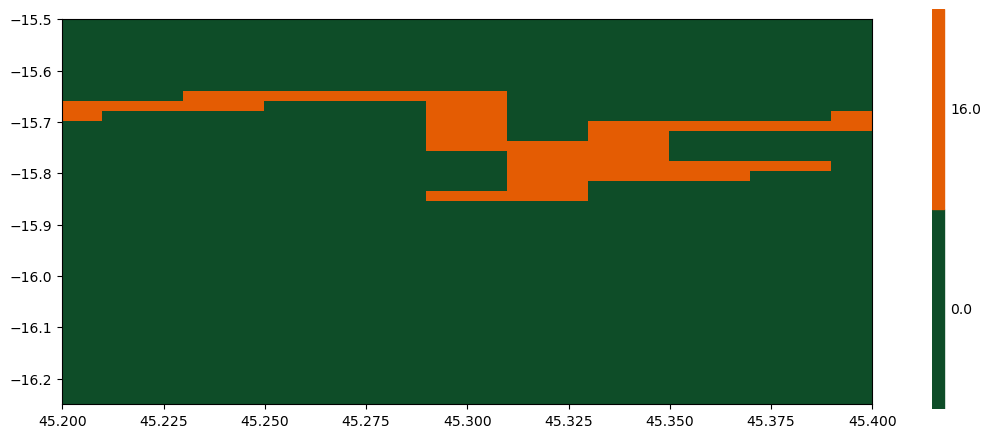

In [129]:
import numpy as np
import matplotlib.pyplot as plt

hist_count, xedges, yedges = np.histogram2d(particle_lon, particle_lat, 
                                             bins=[grid_data.lon_psi[0, :], grid_data.lat_psi[:, 0]])
hist_count = hist_count.T

colours = np.unique(hist_count)
print(colours)

color_map = {colour: np.random.rand(3,) for colour in colours}

color_matrix = np.zeros((hist_count.shape[0], hist_count.shape[1], 3))
for i in range(hist_count.shape[0]):
    for j in range(hist_count.shape[1]):
        color_matrix[i, j] = color_map[hist_count[i, j]]

fig, ax = plt.subplots(figsize=(12, 5))

ax.imshow(color_matrix, interpolation='nearest', origin='lower',
          extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
          aspect='auto')

plt.ylim(-16.25, -15.50)
plt.xlim(45.2, 45.4)

plt.subplots_adjust(right=0.8)
legend_ax = fig.add_axes([0.85, 0.10, 0.03, 0.8])

for i, colour in enumerate(colours):
    legend_ax.add_patch(plt.Rectangle((0, i), 1, 1, color=color_map[colour]))
    legend_ax.text(1.5, i + 0.5, str(colour), verticalalignment='center')

legend_ax.set_xlim(0, 3)
legend_ax.set_ylim(0, len(colours))
legend_ax.axis('off')

plt.show()


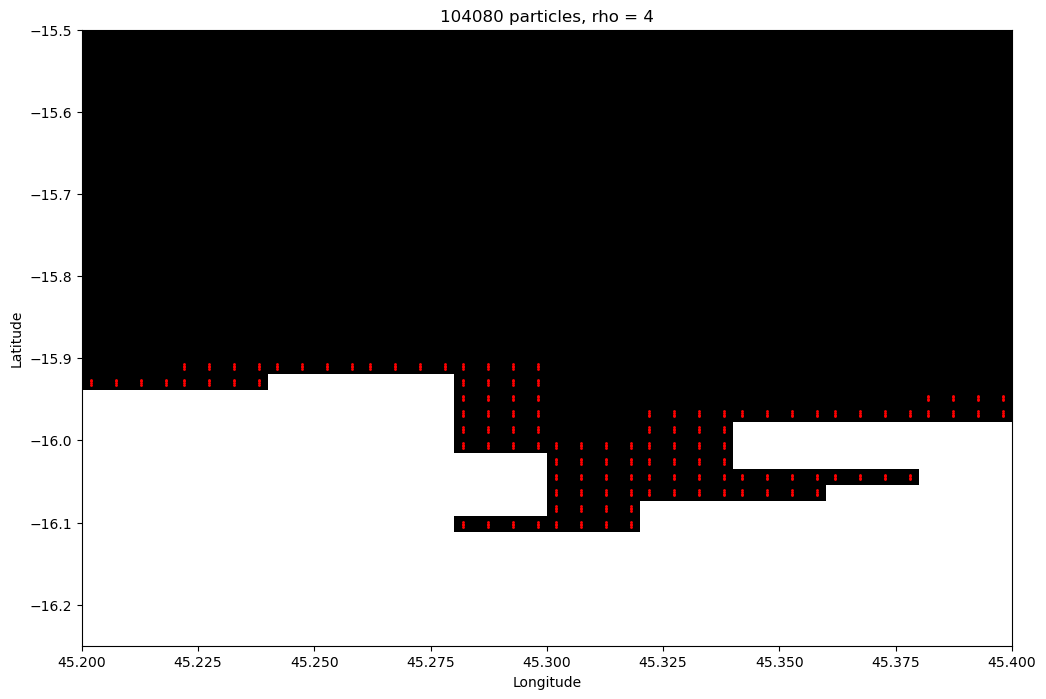

In [109]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt


file_path = '/home/ocean_personal_data/albinski/croco_grd.nc' 
grid_data = xr.open_dataset(file_path)


mask_psi = grid_data['mask_psi'].values
lat_psi = grid_data['lat_psi'].values
lon_psi = grid_data['lon_psi'].values


adjacent_ocean_cells = np.zeros_like(mask_psi, dtype=bool)


for i in range(1, mask_psi.shape[0] - 1):
    for j in range(1, mask_psi.shape[1] - 1):
        #
        if mask_psi[i, j] == 1 and (
            mask_psi[i-1, j] == 0 or mask_psi[i+1, j] == 0 or 
            mask_psi[i, j-1] == 0 or mask_psi[i, j+1] == 0 or
            mask_psi[i-1, j-1] == 0 or mask_psi[i-1, j+1] == 0 or
            mask_psi[i+1, j-1] == 0 or mask_psi[i+1, j+1] == 0):
            adjacent_ocean_cells[i, j] = True


adjacent_ocean_indices = np.argwhere(adjacent_ocean_cells)

particles_per_cell = 4

particle_lons, particle_lats = [], []
lon_contraction_factor = 0.8  # Adjust for east-west contraction
lat_contraction_factor = 0.3  # Adjust for north-south contraction

for i, j in adjacent_ocean_indices:
    # Apply contraction factors separately
    dlon = np.diff(lon_psi[i:i+2, j:j+2], axis=1) * lon_contraction_factor
    dlat = np.diff(lat_psi[i:i+2, j:j+2], axis=0) * lat_contraction_factor

    start_lon = lon_psi[i, j] - dlon[0, 0] / 2 if dlon.size > 0 else lon_psi[i, j]
    start_lat = lat_psi[i, j] - dlat[0, 0] / 2 if dlat.size > 0 else lat_psi[i, j]

    for lat_index in range(particles_per_cell):
        for lon_index in range(particles_per_cell):
            particle_lat = start_lat + (lat_index / (particles_per_cell - 1)) * (dlat[0, 0] if dlat.size > 0 else 0)
            particle_lon = start_lon + (lon_index / (particles_per_cell - 1)) * (dlon[0, 0] if dlon.size > 0 else 0)

            particle_lons.append(particle_lon)
            particle_lats.append(particle_lat)


plt.figure(figsize=(12, 8))
plt.pcolormesh(lon_psi, lat_psi, mask_psi, cmap='bone_r', shading='auto', zorder = 1)
plt.scatter(particle_lons, particle_lats, color='red', s=1, zorder=10)  
n = len(particle_lats)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'{n} particles, rho = {particles_per_cell}')
plt.ylim(-16.25,-15.50)
plt.xlim(45.2, 45.4)
plt.show()


## This is the script that needs to be used to put the particles

Total particles: 104080


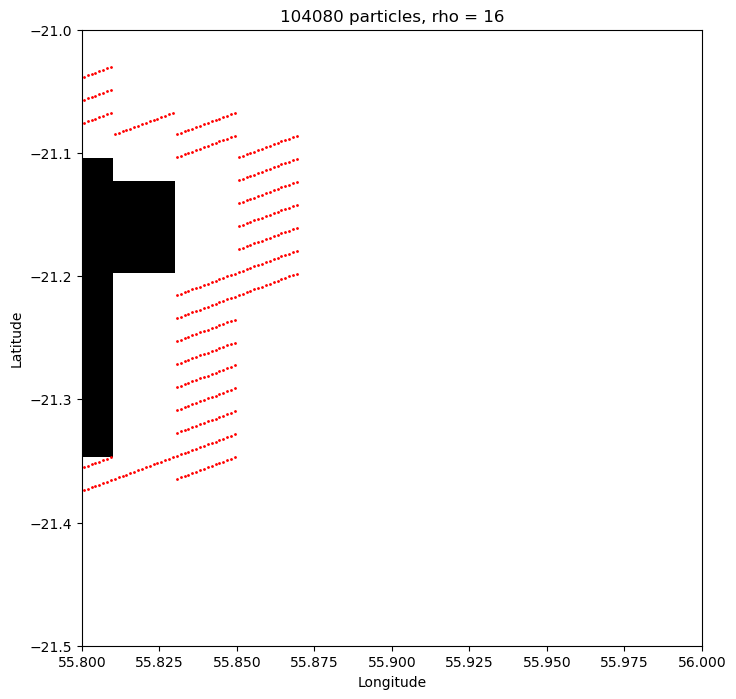

In [2]:
import numpy as np
import xarray as xr
import cmasher as cmr
import matplotlib.pyplot as plt

file_path = '/home/ocean_personal_data/albinski/croco_grd.nc' 
grid_data = xr.open_dataset(file_path)

lon_psi = grid_data['lon_psi'].values
lat_psi = grid_data['lat_psi'].values
mask_psi = grid_data['mask_psi'].values
mask_rho =grid_data['mask_rho'].values

adjacent_ocean_cells = np.zeros_like(mask_psi, dtype=bool)
for i in range(1, mask_psi.shape[0] - 1):
    for j in range(1, mask_psi.shape[1] - 1):
        if mask_psi[i, j] == 1 and (
            mask_psi[i-1, j] == 0 or mask_psi[i+1, j] == 0 or 
            mask_psi[i, j-1] == 0 or mask_psi[i, j+1] == 0 or
            mask_psi[i-1, j-1] == 0 or mask_psi[i-1, j+1] == 0 or
            mask_psi[i+1, j-1] == 0 or mask_psi[i+1, j+1] == 0):
            adjacent_ocean_cells[i, j] = True

particles_per_cell = 16
dlon_psi = np.diff(lon_psi, axis=1)
dlat_psi = np.diff(lat_psi, axis=0)
dlon_psi = np.hstack([dlon_psi, dlon_psi[:, -1:]])
dlat_psi = np.vstack([dlat_psi, dlat_psi[-1:, :]])

lon_starts = lon_psi[:, :, np.newaxis]
lat_starts = lat_psi[:, :, np.newaxis]
lon_quarters = lon_starts + np.linspace(0, 1, particles_per_cell + 1)[:-1] * dlon_psi[:, :, np.newaxis] + dlon_psi[:, :, np.newaxis] / particles_per_cell / 2
lat_quarters = lat_starts + np.linspace(0, 1, particles_per_cell + 1)[:-1] * dlat_psi[:, :, np.newaxis] + dlat_psi[:, :, np.newaxis] / particles_per_cell / 2

masked_lon_quarters = lon_quarters[adjacent_ocean_cells, :]
masked_lat_quarters = lat_quarters[adjacent_ocean_cells, :]
flat_lon_quarters = masked_lon_quarters.reshape(-1)
flat_lat_quarters = masked_lat_quarters.reshape(-1)
valid_positions = ~np.isnan(flat_lon_quarters) & ~np.isnan(flat_lat_quarters)


particle_lon = flat_lon_quarters[valid_positions]
particle_lat = flat_lat_quarters[valid_positions]

np.save('particle_lat_around_land.npy',particle_lat)
np.save('particle_lon_around_land.npy',particle_lon)


print(f'Total particles: {len(particle_lon)}')
grid = xr.open_dataset('/home/ocean_personal_data/albinski/croco_grd.nc')

f, ax = plt.subplots(1, 1, figsize=(8, 8))

# Plot the land-sea mask
ax.pcolormesh(grid.lon_psi[0, :],
              grid.lat_psi[:, 0],
              grid.mask_rho[1:-1, 1:-1],
              cmap=cmr.neutral, zorder=1)
plt.scatter(particle_lon, particle_lat, color='red', s=1, zorder=10)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'{len(particle_lat)} particles, rho = {particles_per_cell}')
plt.ylim(-21.5,-21)
plt.xlim(55.8,56)
plt.show()

Text(0, 0.5, 'Latitude')

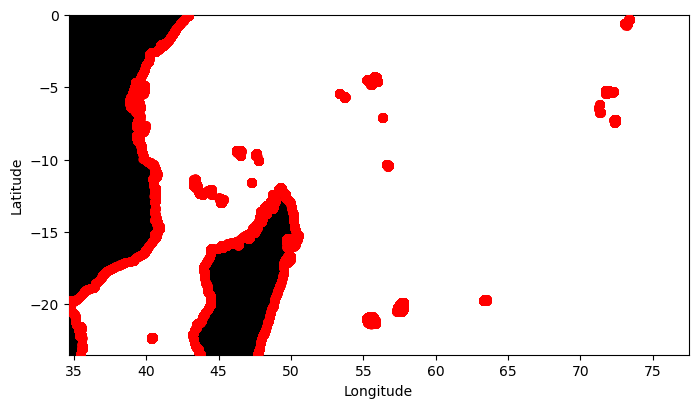

In [9]:
data = xr.open_zarr('/home/ocean_personal_data/albinski/TrajectoriesWithSubS/1994_02_1w_023.53577.5_20rho_ships.zarr')

f, ax = plt.subplots(1, 1, figsize=(8, 8))

# Plot the land-sea mask
ax.pcolormesh(grid.lon_psi[0, :],
              grid.lat_psi[:, 0],
              grid.mask_rho[1:-1, 1:-1],
              cmap=cmr.neutral, zorder=1)

# Plot the particle trajectories
for traj in data.trajectory:
    ax.plot(data.lon.loc[traj, 3],
            data.lat.loc[traj, 3],
            c='r', marker = '.' ,markersize = 10, zorder=10, lw=0.5)
# Axis settings
fov = 0.3
ax.set_aspect('equal')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
